# Handy
## Process data

Now that you have your frames recorded (if not, see [gathering data](0_Gather_Data.ipynb)), let's process it.

The most effective way I came up with to recognize different "pose gestures" is probably to calculate angles between specific joints, as shown in the figure below.


![Angles](./angles.png)

In [31]:
# Try to load the data
from os import path 

if not path.exists("result.csv"):
    print("The result.csv file doesn't exist! Please first come through the 0_Gather_Data.ipynb notebook.")
    exit(-1)

In [32]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [33]:
import pandas as pd
import numpy as np


df = pd.read_csv("result.csv")

df.head()

,class_name,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,z31,v31,x32,y32,z32,v32,x33,y33,z33,v33
0,0,0.506536,0.616250,-0.161957,0.999961,0.508905,0.607851,-0.157893,0.999866,0.510597,...,0.132577,0.823041,0.496994,0.968532,0.081971,0.967062,0.476776,0.967192,0.081551,0.953807
1,0,0.505973,0.618089,-0.163435,0.999962,0.508608,0.608852,-0.159289,0.999868,0.510198,...,0.063159,0.820521,0.497470,0.969642,0.021748,0.965560,0.476264,0.966539,0.005996,0.953233
2,0,0.505793,0.619601,-0.163468,0.999963,0.508508,0.609905,-0.159393,0.999871,0.510032,...,0.055359,0.816946,0.498406,0.970520,0.014507,0.963082,0.476270,0.965778,-0.000446,0.951665
3,0,0.505720,0.621040,-0.165457,0.999964,0.508468,0.611157,-0.161458,0.999874,0.509945,...,0.073492,0.814338,0.499383,0.972459,0.020810,0.961066,0.476234,0.966702,0.017741,0.950336
4,0,0.505583,0.622469,-0.166670,0.999965,0.508342,0.612603,-0.162738,0.999876,0.509761,...,0.070979,0.808404,0.499269,0.972391,0.022338,0.957294,0.475933,0.966851,0.014630,0.947231


In [34]:
# Number of data per class
df.groupby("class_name").size()

class_name
0    200
1    200
2    200
3    200
4    200
5    200
6    200
7    200
8    200
9    200
dtype: int64

In [35]:
def calculate_angle(a, b, c):
    a = np.array(a)  # First
    b = np.array(b)  # Mid - the angle corner
    c = np.array(c)  # End

    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(
        a[1] - b[1], a[0] - b[0]
    )
    angle = np.abs(radians * 180.0 / np.pi)

    if angle > 180.0:
        angle = 360 - angle

    return angle

In [36]:
# Function to calculate the values for each individual row

# Each row is a numpy array of shape (33,) with each of its item being a tuple of shape (4,)
def calculate_angle_for_single(class_name, row):
    output_row = [class_name]
    
    # Angle 0
    output_row.append(calculate_angle(row[12], row[14], row[16]))
    
    # Angle 1
    output_row.append(calculate_angle(row[11], row[13], row[15]))

    # Angle 2
    output_row.append(calculate_angle(row[14], row[12], row[24]))

    # Angle 3
    output_row.append(calculate_angle(row[13], row[11], row[23]))

    # # Angle 4
    # output_row.append(calculate_angle(row[12], row[0], row[11]))

    # # Angle 5
    # # This one is a little bit special because the middle point (the corner of the angle) isn't a point itself - it's between 24 and 23
    
    # # The same as angle_5_middle = (((row[24][0] + row[23][0]) / 2), ((row[24][1] + row[23][1]) / 2), ((row[24][2] + row[23][2]) / 2), ((row[24][3] + row[23][3]) / 2))
    # angle_5_middle = [(row[24][i] + row[23][i]) / 2 for i in range(len(row[23]))] 
    # # print(row[24])
    # # print(row[23])
    # # print(angle_5_middle)
    # output_row.append(calculate_angle(row[26], angle_5_middle, row[25]))

    return output_row



    

In [37]:
# Converts the dataframe into:
# 1. class_names dataframe with only 1 column: class_name
# 2. result_array numpy array with each of the values grouped to a tuple, i.e. [(x1, y1, z1, v1), (x2, y2, z2, v2), ...]
# the result_array is of shape (len_data, 33) (but it's (len_data, 33, 4))

result = []
column_names = ['x', 'y', 'z', 'v']

class_names = df["class_name"]
values = df.drop("class_name", axis=1)

columns_per_group = len(column_names)
num_groups = len(values.columns) // columns_per_group

result_array = np.empty((len(values), num_groups), dtype=tuple)
for i in range(num_groups):
    start_idx = i * columns_per_group
    end_idx = (i + 1) * columns_per_group
    result_array[:, i] = [tuple(row[start_idx:end_idx]) for row in df.values]


print(f"shape: {result_array.shape}")
print(f"first row: {result_array[0]}")
print(f"first row first group: {result_array[0][0]}")

shape: (2000, 33)
first row: [(0.0, 0.5065358877182007, 0.6162503361701965, -0.1619569957256317)
 (0.9999606609344482, 0.5089053511619568, 0.6078510284423828, -0.157892569899559)
 (0.9998661279678344, 0.5105968713760376, 0.6072729229927063, -0.1578895598649978)
 (0.9998770952224731, 0.5123258233070374, 0.6067014932632446, -0.1578898429870605)
 (0.9998563528060912, 0.5041550397872925, 0.6071304082870483, -0.1595849245786667)
 (0.9998407363891602, 0.5023607611656189, 0.60634845495224, -0.1595713347196579)
 (0.9998483657836914, 0.5004465579986572, 0.6054016351699829, -0.1595651805400848)
 (0.9998281002044678, 0.5136186480522156, 0.6064416170120239, -0.1059810444712638)
 (0.999744713306427, 0.4964552521705627, 0.6046180725097656, -0.1149121522903442)
 (0.999761998653412, 0.5086337924003601, 0.6238988637924194, -0.1397626250982284)
 (0.9999537467956544, 0.5027060508728027, 0.6215731501579285, -0.142236977815628)
 (0.9999523162841796, 0.5258198380470276, 0.6492832899093628, -0.06351755559444

In [38]:
# Now that we have the data grouped, calculate the angles (see the picture at the beginning of this notebook)

rows = []
for index, item in enumerate(result_array):
    output = calculate_angle_for_single(class_names.iloc[index], item)
    rows.append(output)

# We calculate 6 angles in total + there's class_name at the start, so create a pandas dataframe with this shape
# Note: for now, using only 4 angles
df = pd.DataFrame(rows, columns=['class_name'] + [f"angle_{i}" for i in range(4)])

print(df.columns)
df.head()

Index(['class_name', 'angle_0', 'angle_1', 'angle_2', 'angle_3'], dtype='object')


,class_name,angle_0,angle_1,angle_2,angle_3
0,0,165.611195,94.665852,99.971559,89.466641
1,0,164.841297,153.002031,100.425002,24.642394
2,0,165.929141,77.914476,101.095162,101.468012
3,0,165.346025,76.023489,102.053990,102.571696
4,0,165.693190,75.251335,102.945354,102.967431


In [39]:
# Save data to csv file
df.to_csv("data.csv", index=None)

<Axes: title={'center': 'Mean Values by Class'}, xlabel='class_name', ylabel='Mean Values'>

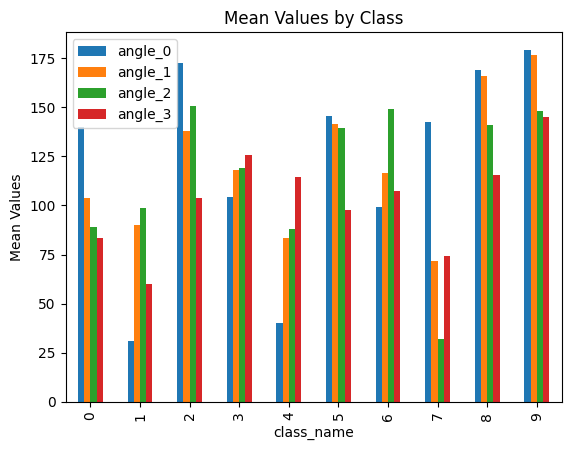

In [40]:
# Group the data by "class_name" and calculate the mean
mean_values = df.groupby('class_name')[
    [f"angle_{angle_index}" for angle_index in range(len(df.columns) - 1)]
].mean()

# Plot the mean values
mean_values.plot(kind='bar', ylabel='Mean Values', title='Mean Values by Class')